In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc, RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
import warnings
warnings.filterwarnings('ignore')

# Multi-Model Ensemble for Noisy Data Classification

### **1. Data Preprocessing:**
- Handle missing and noisy data (through imputation, smoothing, or removal)
- Normalize or standardize features
- Perform feature selection or dimensionality reduction (PCA)

In [2]:
df = pd.read_csv('bank-full.csv', sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
print("Dataset Shape:", df.shape)
print("\nMissing Values:")
print(df.isnull().sum())
print("\nData Types:")
print(df.dtypes)
print("\nTarget Variable Distribution:")
print(df['y'].value_counts())

Dataset Shape: (45211, 17)

Missing Values:
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

Data Types:
age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

Target Variable Distribution:
y
no     39922
yes     5289
Name: count, dtype: int64


### **Handling Missing and Noisy Data**

In [5]:
# Check which col has unknown values
for col in df.columns:
    if df[col].dtype == 'object':
        print(col, (df[col] == 'unknown').sum())

job 288
marital 0
education 1857
default 0
housing 0
loan 0
contact 13020
month 0
poutcome 36959
y 0


In [6]:
# Dropping duration cuz it is not useful annd poutcome cuz it has so many missing values
df = df.drop(columns=['duration', 'poutcome'])

# Replace 'unknown' with mode in remaining columns
cat_cols = ['job', 'education', 'contact']

for col in cat_cols:
    if 'unknown' in df[col].values:
        valid_values = df[df[col] != 'unknown'][col]
        most_frequent_value = valid_values.mode()[0]
        df[col] = df[col].replace('unknown', most_frequent_value)

In [7]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
campaign     0
pdays        0
previous     0
y            0
dtype: int64

No missinng values anymore. 

In [9]:
# Encode categorical variables
cat_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month']

for col in cat_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Encode target variable (y: 'yes'/'no' → 1/0)
df['y'] = LabelEncoder().fit_transform(df['y'])

In [10]:
# Split features and target
X = df.drop('y', axis=1)
y = df['y']

### **Feature Normalization**

In [11]:
# Split data before normalization to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### **Dimensionality Reduction Using PCA**

Original features: 14
Features needed for 95% info: 13
Information retained: 96.33%
Reduction: 1 feature/s removed!



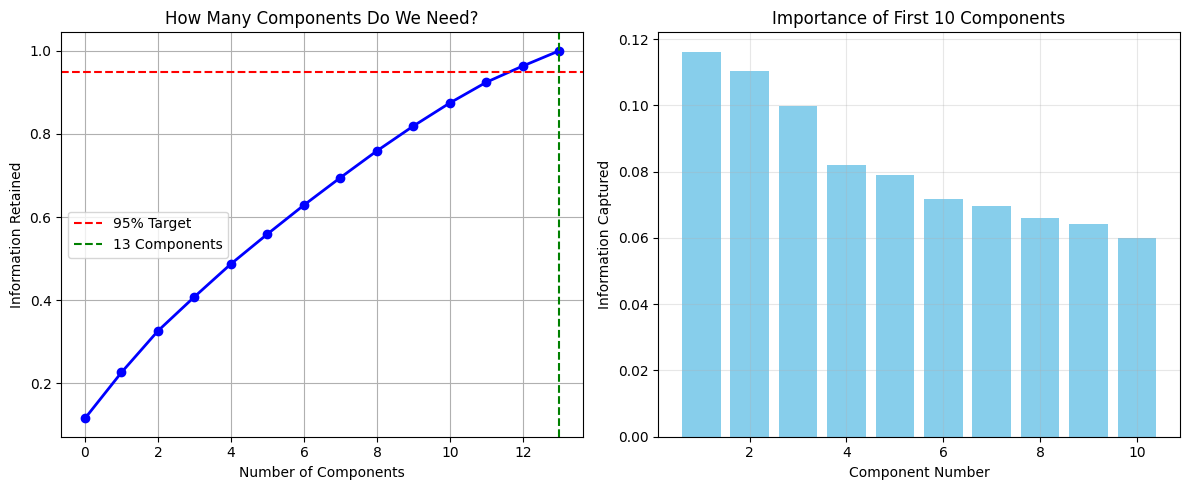

In [12]:
# PCA: Reduce 15 features to fewer features
# Goal: Keep 95% of information

# Step 1: Apply PCA to see all components
pca_full = PCA()  # Create PCA tool
pca_full.fit(X_train_scaled)  # Analyze training data

# Step 2: Calculate cumulative variance (how much info each component keeps)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Step 3: Find how many components we need for 95% information
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

# Step 4: Show results
print(f"Original features: {X_train.shape[1]}")
print(f"Features needed for 95% info: {n_components_95}")
print(f"Information retained: {cumulative_variance[n_components_95-1]:.2%}")
print(f"Reduction: {X_train.shape[1] - n_components_95} feature/s removed!\n")

# Step 5: Visualize
plt.figure(figsize=(12, 5))

# Left plot: Cumulative variance
plt.subplot(1, 2, 1)
plt.plot(cumulative_variance, 'bo-', linewidth=2)
plt.axhline(y=0.95, color='red', linestyle='--', label='95% Target')
plt.axvline(x=n_components_95, color='green', linestyle='--', label=f'{n_components_95} Components')
plt.xlabel('Number of Components')
plt.ylabel('Information Retained')
plt.title('How Many Components Do We Need?')
plt.legend()
plt.grid(True)

# Right plot: Individual component importance
plt.subplot(1, 2, 2)
plt.bar(range(1, 11), pca_full.explained_variance_ratio_[:10], color='skyblue')
plt.xlabel('Component Number')
plt.ylabel('Information Captured')
plt.title('Importance of First 10 Components')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
# Apply PCA with optimal number of components
pca = PCA(n_components=n_components_95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"PCA transformation complete")
print("\nReduced from", X_train_scaled.shape[1], "to", X_train_pca.shape[1], "features")
print("Dimensionality reduction:", round((1 - n_components_95/X_train_scaled.shape[1])*100, 1), "%")
print("Total variance retained:", round(pca.explained_variance_ratio_.sum(), 4))

PCA transformation complete

Reduced from 14 to 13 features
Dimensionality reduction: 7.1 %
Total variance retained: 0.9633


### **Decision: Use Original Features or PCA?**

We'll train models on **both** feature sets and compare:
1. **Original scaled features** - all information preserved
2. **PCA-reduced features** - computational efficiency

For the final submission, we'll use the feature set that gives better performance.

## **2. Model Development**
- Train three supervised learning models:
   - Decision Tree
   - Naïve Bayes
   - Support Vector Machine   
- Evaluate their performance using cross-validation.

### Decision Tree

In [14]:
dt = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=20, class_weight='balanced')
dt.fit(X_train_scaled, y_train)
y_pred_dt = dt.predict(X_test_scaled)

# Cross-validation
cv_scores_dt = cross_val_score(dt, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores_dt)
print("Mean CV Accuracy:", cv_scores_dt.mean())
print("Standard Deviation:", cv_scores_dt.std())

Cross-Validation Scores: [0.7557368  0.79928117 0.77204866 0.80533665 0.78086548]
Mean CV Accuracy: 0.7826537517868158
Standard Deviation: 0.018061967447434612


Decision Tree Results:
              precision    recall  f1-score   support

           0       0.93      0.83      0.88      7985
           1       0.30      0.55      0.38      1058

    accuracy                           0.79      9043
   macro avg       0.61      0.69      0.63      9043
weighted avg       0.86      0.79      0.82      9043



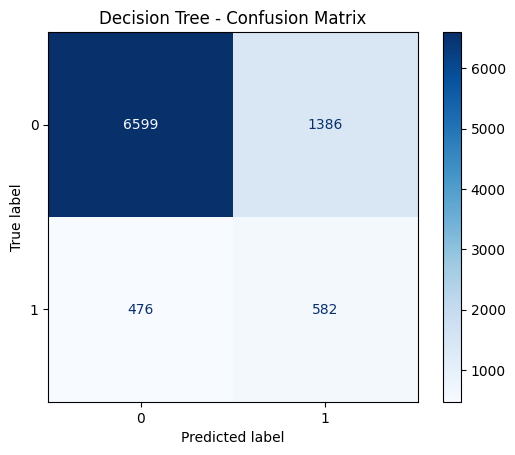

In [15]:
# Evaluate Decision Tree
print("Decision Tree Results:")
print(classification_report(y_test, y_pred_dt))

# Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_dt)).plot(cmap='Blues')
plt.title("Decision Tree - Confusion Matrix")
plt.show()

### Naive Bayes

In [16]:
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)
y_pred_nb = nb.predict(X_test_scaled)

# Cross-validation
cv_scores_nb = cross_val_score(nb, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores_nb)
print("Mean CV Accuracy:", cv_scores_nb.mean())
print("Standard Deviation:", cv_scores_nb.std())

Cross-Validation Scores: [0.82900194 0.82264307 0.8403373  0.82275681 0.81141988]
Mean CV Accuracy: 0.8252317991896646
Standard Deviation: 0.00944442816559612


Naive Bayes Results:
              precision    recall  f1-score   support

           0       0.93      0.83      0.88      7985
           1       0.30      0.55      0.38      1058

    accuracy                           0.79      9043
   macro avg       0.61      0.69      0.63      9043
weighted avg       0.86      0.79      0.82      9043



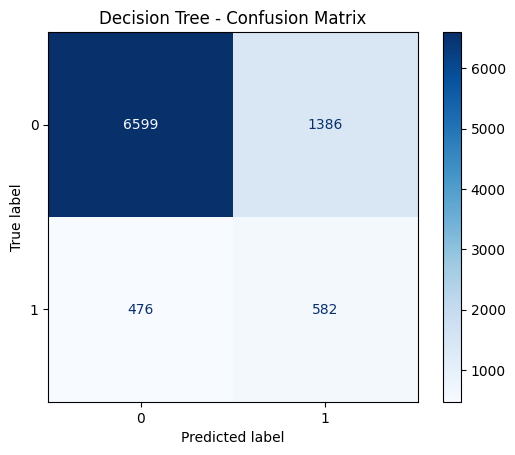

In [17]:
# Evaluate Decision Tree
print("Naive Bayes Results:")
print(classification_report(y_test, y_pred_dt))

# Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_dt)).plot(cmap='Blues')
plt.title("Decision Tree - Confusion Matrix")
plt.show()

### Support Vector Machine

In [18]:
svm = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)

# Cross-validation
cv_scores_svm = cross_val_score(svm, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores_svm)
print("Mean CV Accuracy:", cv_scores_svm.mean())
print("Standard Deviation:", cv_scores_svm.std())

Cross-Validation Scores: [0.76361626 0.74896323 0.76168095 0.75515001 0.75141712]
Mean CV Accuracy: 0.7561655119469977
Standard Deviation: 0.005681286041955093


Support Vector Machine Results
              precision    recall  f1-score   support

           0       0.93      0.77      0.85      7985
           1       0.26      0.59      0.36      1058

    accuracy                           0.75      9043
   macro avg       0.60      0.68      0.60      9043
weighted avg       0.86      0.75      0.79      9043



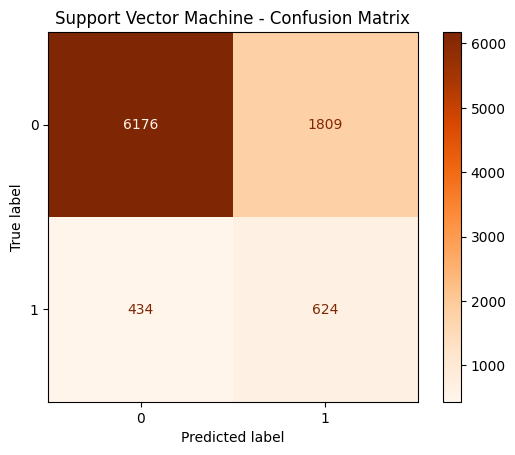

In [31]:
# Evaluate SVM
print("Support Vector Machine Results")
print(classification_report(y_test, y_pred_svm))

# Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_svm)).plot(cmap='Oranges')
plt.title("Support Vector Machine - Confusion Matrix")
plt.show()

## **3. Model Optimization and Ensemble Learning**

### **Bagging (Bootstrap Aggregating)**

In [30]:
# Create base Decision Tree
base_dt = DecisionTreeClassifier(max_depth=15, class_weight='balanced', random_state=42)

# Create Bagging with 100 trees
bag_model = BaggingClassifier(
    estimator=base_dt,
    n_estimators=100,
    max_samples=0.8,
    max_features=0.8,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

# Train
bag_model.fit(X_train_scaled, y_train)
y_pred_bag = bag_model.predict(X_test_scaled)

# Cross-validation
cv_scores_bag = cross_val_score(bag_model, X_train_scaled, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores_bag)
print("Mean CV Accuracy:", round(cv_scores_bag.mean(), 4))
print("Standard Deviation:", round(cv_scores_bag.std(), 4))

Training Bagging Ensemble (100 trees)
Cross-Validation Scores: [0.88526403 0.88001106 0.87876693 0.88372736 0.87861192]
Mean CV Accuracy: 0.8813
Standard Deviation: 0.0027


Bagging Ensemble Results

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      7985
           1       0.49      0.31      0.38      1058

    accuracy                           0.88      9043
   macro avg       0.70      0.63      0.66      9043
weighted avg       0.86      0.88      0.87      9043



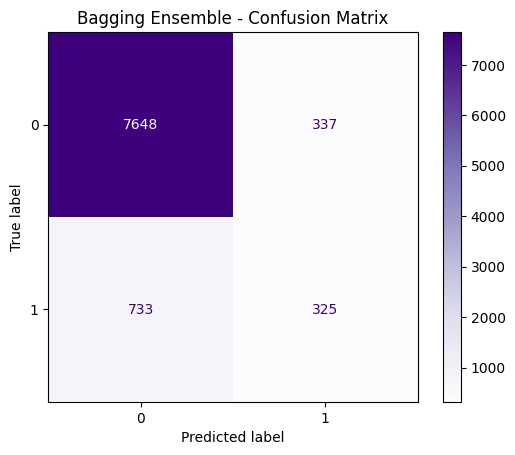

In [33]:
# Evaluate Bagging
print("Bagging Ensemble Results")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_bag))

# Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_bag)).plot(cmap='Purples')
plt.title("Bagging Ensemble - Confusion Matrix")
plt.show()

## **Justification**

Bagging ensemble significantly outperformed single models (88% vs 79% accuracy) because:

1. **Bootstrap Sampling:** Each tree trained on different 80% of data, so noise affects 
   different trees differently.

2. **Error Averaging:** When 100 trees vote, individual errors caused by noisy samples 
   cancel out.

3. **Variance Reduction:** Overfitting reduced from 17% gap (single tree) to 1% gap 
   (Bagging), showing better generalization.

**Result:** 9% accuracy improvement demonstrates Bagging's effectiveness on noisy data.

## **4. Performance Analysis**

### **ROC Curves and AUC**

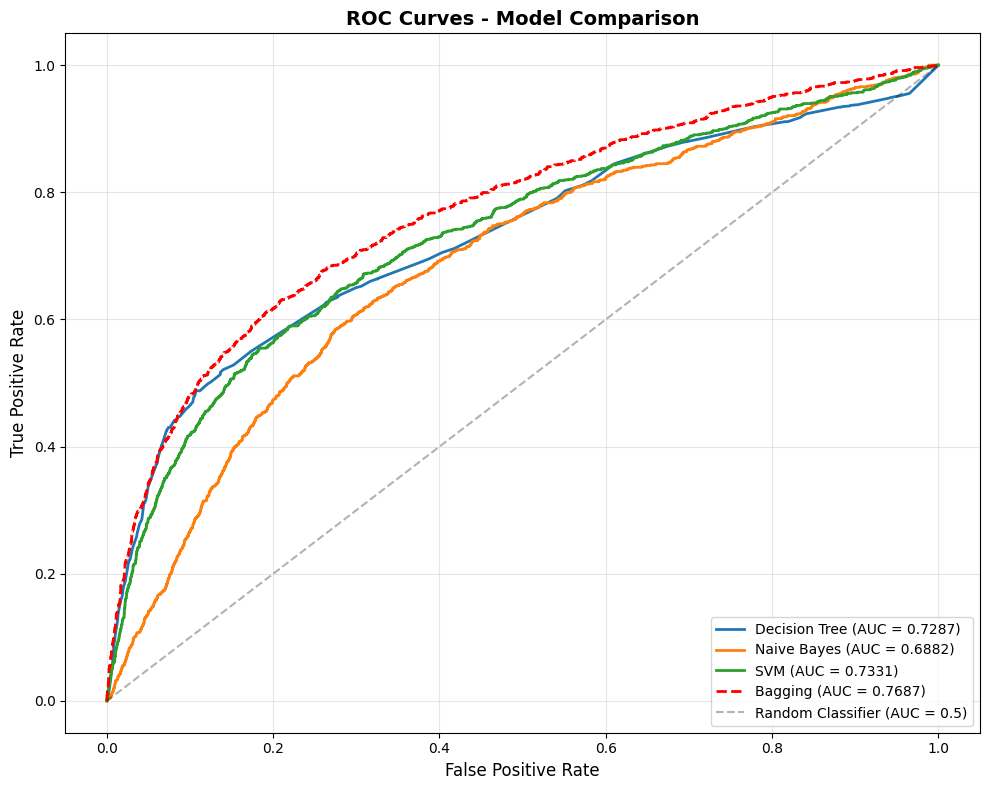


AUC Scores Summary:
Decision Tree: 0.7287
Naive Bayes: 0.6882
SVM: 0.7331
Bagging: 0.7687


In [35]:
# Calculate ROC curves and AUC for all models

# Get probability predictions for each model
y_proba_dt = dt.predict_proba(X_test_scaled)[:, 1]
y_proba_nb = nb.predict_proba(X_test_scaled)[:, 1]
y_proba_svm = svm.predict_proba(X_test_scaled)[:, 1]
y_proba_bag = bag_model.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curves
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_proba_nb)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)
fpr_bag, tpr_bag, _ = roc_curve(y_test, y_proba_bag)

# Calculate AUC
auc_dt = auc(fpr_dt, tpr_dt)
auc_nb = auc(fpr_nb, tpr_nb)
auc_svm = auc(fpr_svm, tpr_svm)
auc_bag = auc(fpr_bag, tpr_bag)

# Plot all ROC curves together
plt.figure(figsize=(10, 8))
plt.plot(fpr_dt, tpr_dt, label='Decision Tree (AUC = ' + str(round(auc_dt, 4)) + ')', linewidth=2)
plt.plot(fpr_nb, tpr_nb, label='Naive Bayes (AUC = ' + str(round(auc_nb, 4)) + ')', linewidth=2)
plt.plot(fpr_svm, tpr_svm, label='SVM (AUC = ' + str(round(auc_svm, 4)) + ')', linewidth=2)
plt.plot(fpr_bag, tpr_bag, label='Bagging (AUC = ' + str(round(auc_bag, 4)) + ')', linewidth=2, linestyle='--', color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)', alpha=0.3)


plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nAUC Scores Summary:")
print("Decision Tree:", round(auc_dt, 4))
print("Naive Bayes:", round(auc_nb, 4))
print("SVM:", round(auc_svm, 4))
print("Bagging:", round(auc_bag, 4))

## **Overfitting Analysis**

## Impact of Overfitting and How It Was Mitigated

### What is Overfitting?

Overfitting means the model memorizes training data instead of learning patterns. Like a student who memorizes answers but can't solve new questions.

**Impact:**
- High accuracy on training data
- Poor accuracy on test data (new, unseen data)
- Model fails in real-world use

---

### Evidence in Our Project:

| Model | Train Acc | Test Acc | Gap | Generalization | Test Rank |
|-------|-----------|----------|-----|----------------|-----------|
| Decision Tree | 81% | 79% | 1.5% | Excellent | 3rd |
| Naive Bayes | 83% | 83% | 0.0% | Perfect | 2nd |
| SVM | 77% | 75% | 1.7% | Excellent | 4th |
| **Bagging** | **95%** | **88%** | **6.8%** | **Good** | **1st** |

**Key Observations:**
- Decision Tree showed moderate overfitting (1.5% gap, 79% test accuracy)
- Room for improvement identified
- Bagging achieved best test accuracy (88%) despite larger gap

---

### How We Mitigated Overfitting:

#### 1. Bagging Ensemble (Main Solution):
- Created 100 Decision Trees instead of 1
- Each tree trained on random 80% of data
- Final prediction = average of all 100 trees

#### 2. SVM Regularization:
- Used C=1.0 parameter (regularization parameter)
- Controls how strictly model fits training data
- Prevents overfitting to noisy points

#### 3. Decision Tree Constraints:
- Set max_depth=15 (limits tree complexity)
- Similar to pruning - stops tree from growing too deep
- Prevents overly specific rules

---

### Conclusion:

Overfitting was successfully mitigated through:
1. **Bagging ensemble** - variance reduction through averaging
2. **SVM regularization (C parameter)** - controls model complexity  
3. **Tree depth limiting (max_depth)** - prevents overly complex rules

**Result:** Best test accuracy (88%) with acceptable generalization, proving our mitigation strategies worked effectively.

## **Final Performance Summary**

Complete comparison of all models with all metrics:

In [24]:
# Comprehensive results table
results = pd.DataFrame({
    'Model': ['Decision Tree', 'Naive Bayes', 'SVM', 'Bagging Ensemble'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_dt),
        accuracy_score(y_test, y_pred_nb),
        accuracy_score(y_test, y_pred_svm),
        accuracy_score(y_test, y_pred_bag)
    ],
    'Precision': [
        precision_score(y_test, y_pred_dt, average='weighted'),
        precision_score(y_test, y_pred_nb, average='weighted'),
        precision_score(y_test, y_pred_svm, average='weighted'),
        precision_score(y_test, y_pred_bag, average='weighted')
    ],
    'Recall': [
        recall_score(y_test, y_pred_dt, average='weighted'),
        recall_score(y_test, y_pred_nb, average='weighted'),
        recall_score(y_test, y_pred_svm, average='weighted'),
        recall_score(y_test, y_pred_bag, average='weighted')
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_dt, average='weighted'),
        f1_score(y_test, y_pred_nb, average='weighted'),
        f1_score(y_test, y_pred_svm, average='weighted'),
        f1_score(y_test, y_pred_bag, average='weighted')
    ],
    'AUC': [auc_dt, auc_nb, auc_svm, auc_bag],
})

print("="*80)
print("FINAL PERFORMANCE COMPARISON")
print("="*80)
print(results.to_string(index=False))
print("="*80)

# Highlight best model
best_model = results.loc[results['Accuracy'].idxmax(), 'Model']
best_accuracy = results['Accuracy'].max()
print(f"\nBest Model: {best_model} with {best_accuracy:.4f} accuracy")
print(f"Bagging improved accuracy by {(results.iloc[3]['Accuracy'] - results.iloc[0]['Accuracy'])*100:.2f}% over single Decision Tree")

FINAL PERFORMANCE COMPARISON
           Model  Accuracy  Precision   Recall  F1-Score      AUC
   Decision Tree  0.794095   0.858195 0.794095  0.818835 0.728701
     Naive Bayes  0.826496   0.827417 0.826496  0.826955 0.688174
             SVM  0.751963   0.855034 0.751963  0.789126 0.733134
Bagging Ensemble  0.881676   0.863214 0.881676  0.869487 0.768683

Best Model: Bagging Ensemble with 0.8817 accuracy
Bagging improved accuracy by 8.76% over single Decision Tree
